In [1]:
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential

In [2]:
import pandas as pd
### Read the data and parse the date columns into datetime format, as well as set the date columns as indexes, 
###the dataset should have been 128544 rows, but is currently 128156 rows, there are missing values
df=pd.read_csv(r'C:\\Users\\86130\\00.Project\\03.Datasets\\Regional 15 minutes load data-10-21.csv',
               sep=',',  ###Set the separator for the data
                     index_col='datatime',  ###set index
                     na_values=['?', 0, 'nan'],  ###set na_vallues
               parse_dates= ['datatime'] )### Convert directly to time format Simple operation

In [4]:
data=df
data.head()

,total power usage（kw）
datatime,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [5]:
data_fill = data.resample('15T').mean()
data_fill[data_fill.isna().iloc[:,0]] = data.median()

In [6]:
data_fill.to_csv(r"C:\Users\86130\00.Project\00.Data Preprocessing\Resample Median data fill 15mins.csv",index=True,header=True) 

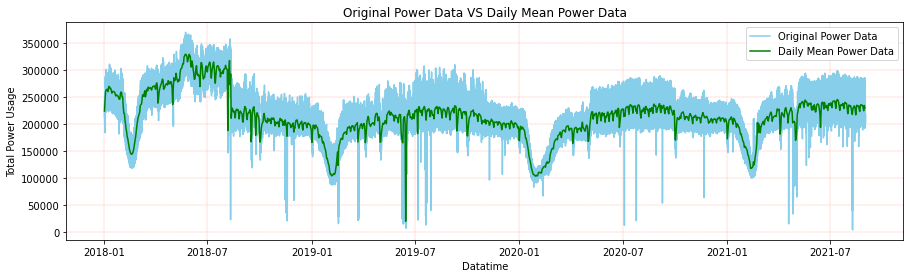

In [7]:
plt.figure(figsize=(15,4))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.plot(data_fill,label='Original Power Data',color='skyblue')
plt.plot(data_fill.resample('D').mean(),label='Daily Mean Power Data',color='green')
plt.title('Original Power Data VS Daily Mean Power Data')
plt.ylabel('Total Power Usage')
plt.xlabel('Datatime')
plt.legend()###Plot of power load data vs. daily average power curve

In [8]:
#### Subtract the data from 96 points in time for each day from the average data for that day's power, 
####so that the data for all points change on a horizontal line
data_day_mean=data_fill.resample('D').mean().values
data_values=[data_fill.iloc[i+96*j,0]-data_day_mean[j][0] for j in range(1339) for i in range(96)]

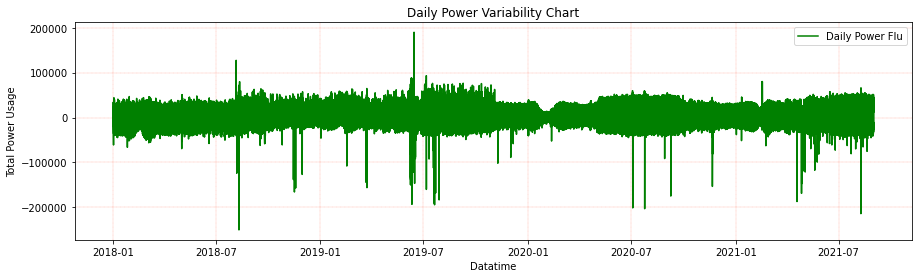

In [9]:
dti=pd.date_range("2018-01-01",periods=128544,freq="15T")
plt.figure(figsize=(15,4))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Daily Power Variability Chart')
plt.ylabel('Total Power Usage')
plt.xlabel('Datatime')
plt.plot(dti,data_values,color='green',label='Daily Power Flu')
plt.legend()##daily power curve

In [10]:
## Utilizing the principle of normal distribution Calculating outliers
data_values=pd.Series(data_values)
mean=data_values.mean()
std=data_values.std()
rule=(mean-3*std > data_values) | (mean+3*std < data_values)
rule.sum()

362

In [11]:
data_del_wrong=data_values.copy()
###Fill the anomaly with the median first, so that the anomaly falls in most of the value range
data_del_wrong[rule]=data_values.median()
###Then use the sliding average to assign values to the anomaly so that the anomaly's value is continuous with the surrounding 10 data points
data_del_wrong[rule]=pd.Series(data_del_wrong).rolling(10,center=True).mean()[rule]
data_smooth=pd.Series(data_del_wrong)

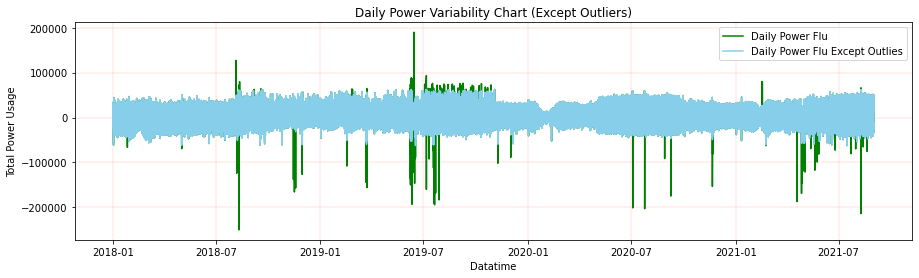

In [12]:
dti=pd.date_range("2018-01-01",periods=128544,freq="15T")
plt.figure(figsize=(15,4))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Daily Power Variability Chart (Except Outliers)')
plt.ylabel('Total Power Usage')
plt.xlabel('Datatime')
plt.plot(dti,data_values,color='green',label='Daily Power Flu')
plt.plot(dti,data_smooth,color='skyblue',label='Daily Power Flu Except Outlies')
plt.legend()

In [13]:
data_smooth.head()

0    20632.702162
1     9319.574162
2     8284.623062
3     4180.265662
4    10081.360862
dtype: float64

In [14]:
dw=data_smooth
dw.head()

0    20632.702162
1     9319.574162
2     8284.623062
3     4180.265662
4    10081.360862
dtype: float64

In [15]:
data_smooth=np.asarray(data_smooth)

In [16]:
#### Normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data_smooth.reshape(-1,1))[:,0]
data_scaled

array([0.66373188, 0.57322189, 0.56494183, ..., 0.26429583, 0.2623204 ,
       0.25126351])

In [17]:
def dataset(df,win_size=96):
    X = []
    Y = []
    for i in range(len(df)-win_size):
        temp_x = df[i:i+win_size]
        temp_y = df[i+win_size]
        X.append(temp_x)
        Y.append(temp_y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [15]:
data_x, data_y = dataset(data_scaled,96)

In [16]:
data_x = np.expand_dims(data_x,axis=1)

In [17]:
from sklearn.model_selection import train_test_split,cross_val_score
import tensorflow as tf
from keras.layers import LSTM,Dense
from keras.models import Sequential
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y,test_size=0.2,shuffle=False)
model =  Sequential()
model.add(LSTM(256,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Dense(1,activation='sigmoid'))

In [18]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x,train_y,epochs=18,batch_size=64,validation_split=0.2,shuffle=False)

Epoch 1/18
1285/1285 [==============================] - 11s 8ms/step - loss: 0.0040 - val_loss: 8.4736e-04
Epoch 2/18
1285/1285 [==============================] - 10s 7ms/step - loss: 0.0029 - val_loss: 6.7442e-04
Epoch 3/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0027 - val_loss: 5.8617e-04
Epoch 4/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0026 - val_loss: 5.4796e-04
Epoch 5/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0025 - val_loss: 5.3256e-04
Epoch 6/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0025 - val_loss: 5.2607e-04
Epoch 7/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0025 - val_loss: 5.2335e-04
Epoch 8/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0024 - val_loss: 5.1917e-04
Epoch 9/18
1285/1285 [==============================] - 10s 8ms/step - loss: 0.0024 - val_loss: 5.1578e-04
Epoch 10/18
1285/1285 [==============

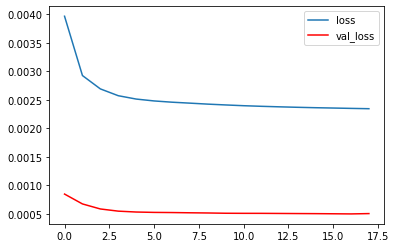

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],c='r')
plt.legend(['loss','val_loss'])
#plt.show()

In [20]:
# model.save('good_pre_model.h5')
y_pred = model.predict(test_x)

803/803 [==============================] - 2s 2ms/step


In [21]:
from sklearn.metrics import r2_score
r2_score(test_y,y_pred)

0.9685297677180453

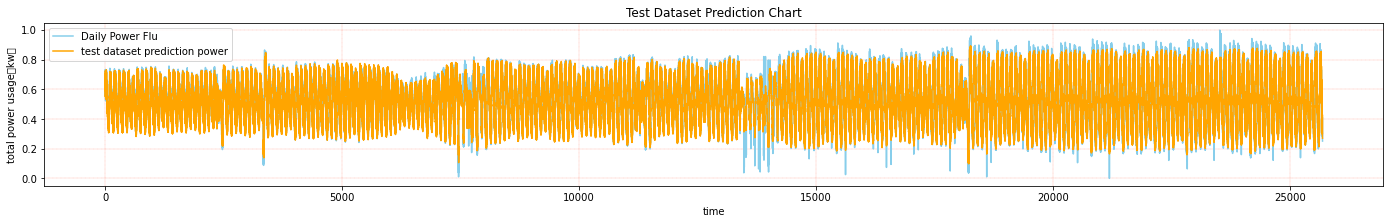

In [22]:
plt.figure(figsize=(24,3))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Test Dataset Prediction Chart')
plt.ylabel('total power usage（kw）')
plt.xlabel('time')
plt.plot(test_y[:],color='skyblue',label='Daily Power Flu')
plt.plot(y_pred[:],color='orange',label='test dataset prediction power')
plt.legend()

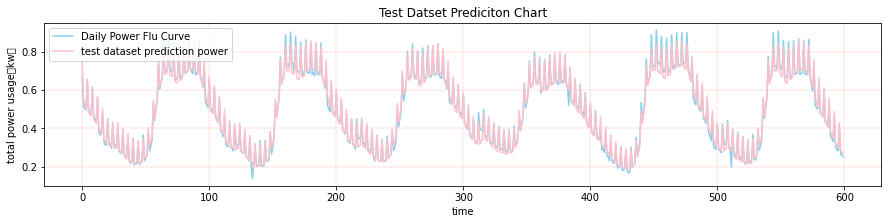

In [23]:
plt.figure(figsize=(15,3))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Test Datset Prediciton Chart')
plt.ylabel('total power usage（kw）')
plt.xlabel('time')
plt.plot(test_y[-600:],color='skyblue',label='Daily Power Flu Curve')
plt.plot(y_pred[-600:],color='pink',label='test dataset prediction power')
plt.legend()#### Predictive rendering of the test set

In [24]:
def predict_all(model, last_x, num=24):
    pred_y = []
    for i in range(num):
        temp_y = model.predict(last_x)
        pred_y.append(temp_y[0, 0])
        # Reshape temp_y as needed to match the shape of last_x
        temp_y = np.expand_dims(temp_y, 0)
        last_x = np.concatenate([last_x[:, :, 1:], temp_y], axis=2)
    return np.asarray(pred_y)

In [25]:
last_x = test_x[-1]
last_x = np.expand_dims(last_x,0)

In [26]:
series_pre = predict_all(model, last_x, num=960)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 19ms/step


In [27]:
series = scaler.inverse_transform([series_pre])

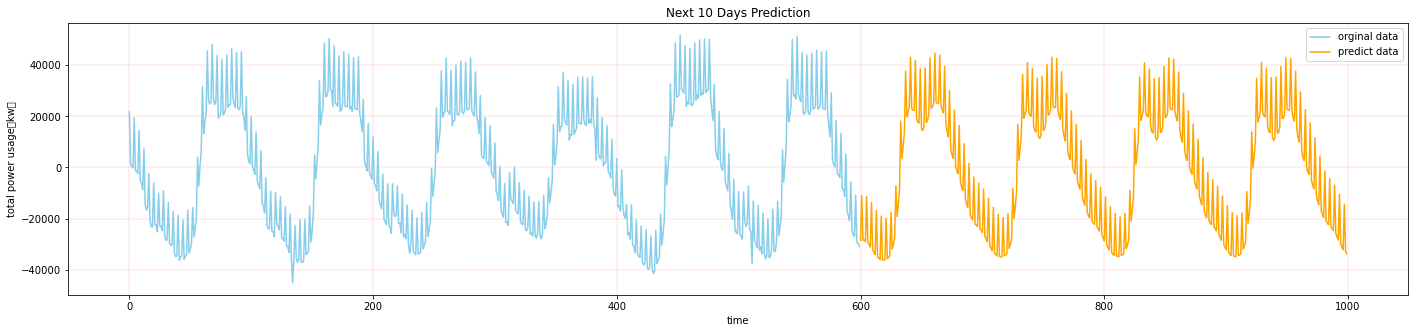

In [28]:
begin = 600
plt.figure(figsize=(24,5))
plt.grid(color='tomato',linestyle ='--',linewidth=0.25)
plt.title('Next 10 Days Prediction')
plt.ylabel('total power usage（kw）')
plt.xlabel('time')
plt.plot(range(begin),data_values[-begin:],color='skyblue',label='orginal data')
plt.plot(range(begin,begin+len(series[0,:400])),series[0,:400],color='orange',label='predict data')
plt.legend()
plt.savefig('Next 10 Days Flu.svg')

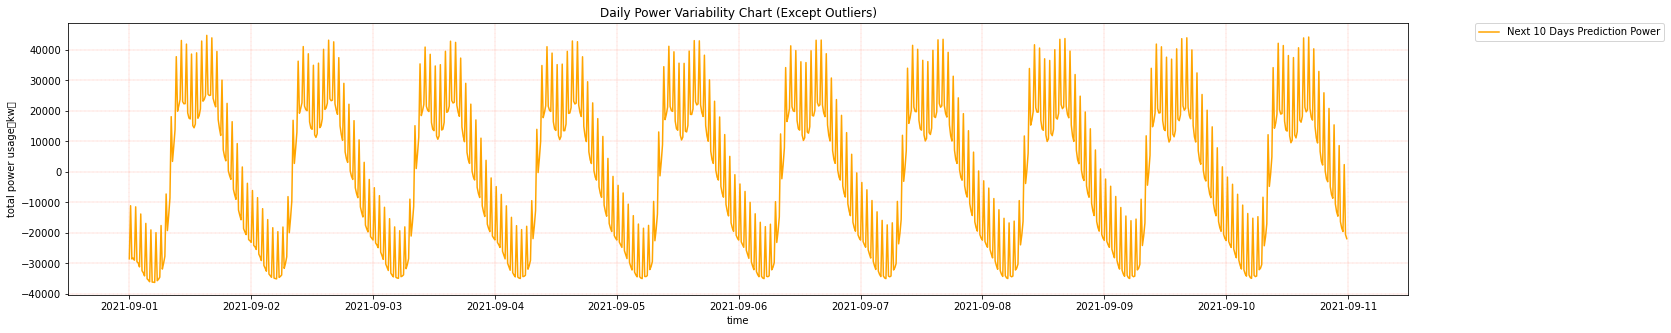

In [29]:
dtip = pd.date_range("2021-09-01",periods=960,freq="15T")
plt.figure(figsize=(24,5))
plt.grid(color='tomato',linestyle='--',linewidth=0.25)
plt.title('Daily Power Variability Chart (Except Outliers)')
plt.ylabel('total power usage（kw）')
plt.xlabel('time')
plt.plot(dtip,series[0,:],color='orange',label='Next 10 Days Prediction Power')
plt.legend(bbox_to_anchor=(1.05,1),borderaxespad=0)

In [30]:
predict_daily_change = pd.DataFrame(series[0],index=pd.date_range('2021-09-01 00:00:00','2021-09-10 23:45:00',freq='15T'),columns=['total power usage (kw)'])
predict_daily_change.index.name = 'datatime'

In [31]:
predict_daily_change

,total power usage (kw)
datatime,
2021-09-01 00:00:00,-28478.759904
2021-09-01 00:15:00,-11080.135702
2021-09-01 00:30:00,-28522.116178
2021-09-01 00:45:00,-28239.315113
2021-09-01 01:00:00,-28915.556016
...,...
2021-09-10 22:45:00,-18384.589420
2021-09-10 23:00:00,-19538.714132
2021-09-10 23:15:00,2400.543820
